# Regression Model Between Electric Motor Parameters

## Context
***

The data set comprises several sensor data collected from a permanent magnet synchronous motor (PMSM) deployed on a test bench. The PMSM represents a german OEM's prototype model. Test bench measurements were collected by the LEA department at Paderborn University. 
This data set is mildly anonymized.

## Content
***

All recordings are sampled at 2 Hz. The data set consists of multiple measurement sessions, which can be distinguished from each other by column "profile_id". A measurement session can be between one and six hours long.

The motor is excited by hand-designed driving cycles denoting a reference motor speed and a reference torque.
Currents in d/q-coordinates (columns "id" and iq") and voltages in d/q-coordinates (columns "ud" and "uq") are a result of a standard control strategy trying to follow the reference speed and torque.
Columns "motor_speed" and "torque" are the resulting quantities achieved by that strategy, derived from set currents and voltages.

Most driving cycles denote random walks in the speed-torque-plane in order to imitate real world driving cycles to a more accurate degree than constant excitations and ramp-ups and -downs would.

## Inspiration
***

The most interesting target features are rotor temperature ("pm"), stator temperatures ("stator_*") and torque.
Especially rotor temperature and torque are not reliably and economically measurable in a commercial vehicle.

Being able to have strong estimators for the rotor temperature helps the automotive industry to manufacture motors with less material and enables control strategies to utilize the motor to its maximum capability.
A precise torque estimate leads to more accurate and adequate control of the motor, reducing power losses and eventually heat build-up.

## References
***
- [Kaggle](https://www.kaggle.com/wkirgsn/electric-motor-temperature)

## License
***

- [Apache-2.0](https://opensource.org/licenses/Apache-2.0)


## Sections
***
- [Basic Linear Regression](#chapter1)
- [Multiple Linear Regression](#chapter2)
- [Principle Component Regression](#chapter3)
- [KNN Regression](#chapter4)
- [Polynomial Regression](#chapter5)

In [1]:
from sklearn import linear_model
from sklearn.metrics import make_scorer
from sklearn import svm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn import neighbors
from math import sqrt


In [2]:
# read data
df = pd.read_csv('/Users/edwinandrew/Documents/Jnotes/Regression-Model-For-Motor-Parameters/input/pmsm_temperature_data.csv', 
                 usecols=[0,1,2,3,4,5,6,7,8,9,10,11])
df.head(10)

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145
5,-0.762936,-1.116955,0.334901,-1.303017,-1.222429,-0.248197,1.031031,-0.246341,-2.522203,-1.831931,-2.062549,-2.017884
6,-0.749228,-1.116170,0.335014,-1.302082,-1.222430,-0.247914,1.030493,-0.246162,-2.522538,-1.833012,-2.062115,-2.017243
7,-0.738450,-1.113986,0.336256,-1.305155,-1.222432,-0.248321,1.030107,-0.246035,-2.522844,-1.832182,-2.061953,-2.017213
8,-0.730910,-1.111828,0.334905,-1.303790,-1.222432,-0.247785,1.029851,-0.245981,-2.522808,-1.831576,-2.062443,-2.017739
9,-0.727130,-1.109486,0.335988,-1.305633,-1.222431,-0.248294,1.029636,-0.245888,-2.522677,-1.831438,-2.062317,-2.018180


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998070 entries, 0 to 998069
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ambient         998070 non-null  float64
 1   coolant         998070 non-null  float64
 2   u_d             998070 non-null  float64
 3   u_q             998070 non-null  float64
 4   motor_speed     998070 non-null  float64
 5   torque          998070 non-null  float64
 6   i_d             998070 non-null  float64
 7   i_q             998070 non-null  float64
 8   pm              998070 non-null  float64
 9   stator_yoke     998070 non-null  float64
 10  stator_tooth    998070 non-null  float64
 11  stator_winding  998070 non-null  float64
dtypes: float64(12)
memory usage: 91.4 MB


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ambient,998070.0,-0.003905,0.993127,-8.573954,-0.599385,0.266157,0.686675,2.967117
coolant,998070.0,0.004723,1.002423,-1.429349,-1.037925,-0.177187,0.650709,2.649032
u_d,998070.0,0.004780,0.997878,-1.655373,-0.826359,0.267542,0.358491,2.274734
u_q,998070.0,-0.005690,1.002330,-1.861463,-0.927390,-0.099818,0.852625,1.793498
motor_speed,998070.0,-0.006336,1.001229,-1.371529,-0.951892,-0.140246,0.853584,2.024164
torque,998070.0,-0.003333,0.997907,-3.345953,-0.266917,-0.187246,0.547171,3.016971
i_d,998070.0,0.006043,0.998994,-3.245874,-0.756296,0.213935,1.013975,1.060937
i_q,998070.0,-0.003194,0.997912,-3.341639,-0.257269,-0.190076,0.499260,2.914185
pm,998070.0,-0.004396,0.995686,-2.631991,-0.672308,0.094367,0.680691,2.917456
stator_yoke,998070.0,0.000609,1.001049,-1.834688,-0.747265,-0.057226,0.697344,2.449158


In [5]:
df.isnull().values.any()

False

In [6]:
# Count the number of NaNs each column has.
nans=pd.isnull(df).sum()
nans[nans>0]

Series([], dtype: int64)

In [7]:
# Count the column types
df.dtypes.value_counts()

float64    12
dtype: int64

In [8]:
df.corr()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding
ambient,1.000000,0.434435,0.194754,0.087430,0.078283,-0.262264,0.005605,-0.260562,0.501496,0.451616,0.396742,0.301883
coolant,0.434435,1.000000,0.178708,0.027851,-0.033332,-0.189617,0.108489,-0.186060,0.430548,0.874037,0.689003,0.509298
u_d,0.194754,0.178708,1.000000,-0.027472,-0.233828,-0.821325,0.358517,-0.796586,-0.082564,0.041428,-0.066256,-0.150714
u_q,0.087430,0.027851,-0.027472,1.000000,0.716897,-0.037262,-0.181855,-0.026348,0.101236,0.106186,0.149017,0.125445
motor_speed,0.078283,-0.033332,-0.233828,0.716897,1.000000,0.024517,-0.722914,0.006323,0.332419,0.182564,0.333909,0.393154
torque,-0.262264,-0.189617,-0.821325,-0.037262,0.024517,1.000000,-0.239059,0.996560,-0.072905,-0.092207,-0.011055,0.080981
i_d,0.005605,0.108489,0.358517,-0.181855,-0.722914,-0.239059,1.000000,-0.204230,-0.299227,-0.179903,-0.387712,-0.539924
i_q,-0.260562,-0.186060,-0.796586,-0.026348,0.006323,0.996560,-0.204230,1.000000,-0.086486,-0.098753,-0.025191,0.060949
pm,0.501496,0.430548,-0.082564,0.101236,0.332419,-0.072905,-0.299227,-0.086486,1.000000,0.695014,0.768352,0.729561
stator_yoke,0.451616,0.874037,0.041428,0.106186,0.182564,-0.092207,-0.179903,-0.098753,0.695014,1.000000,0.949898,0.845144


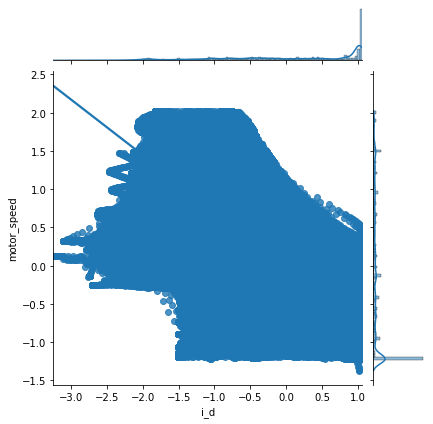

In [9]:

sns.jointplot(x='i_d', y='motor_speed', data=df, kind='reg')

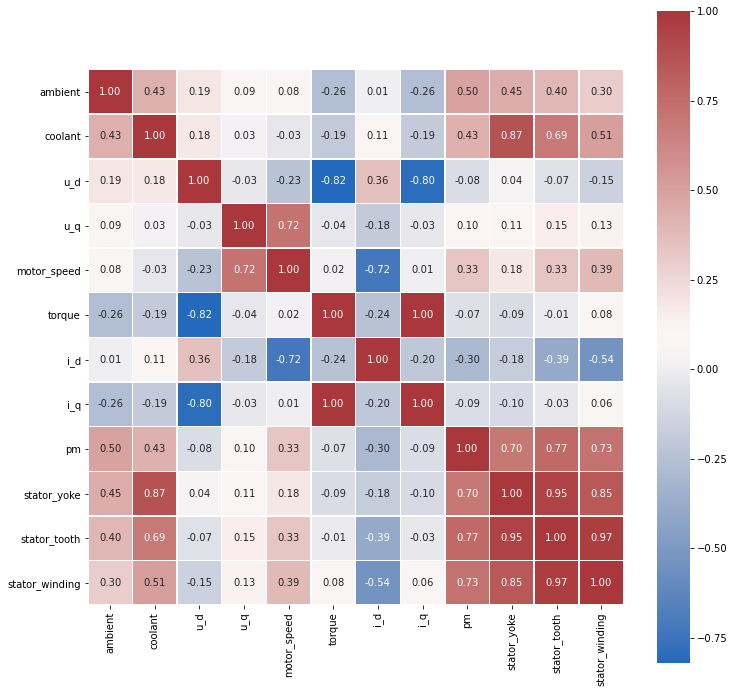

In [10]:
#correlation map
f,ax=plt.subplots(figsize=(12,12))
corr=df.corr()

sns.heatmap(corr, annot=True, linewidths=.5, fmt='.2f', 
            mask= np.zeros_like(corr,dtype=np.bool), 
            cmap="vlag", 
            square=True, ax=ax)

plt.show()

There are high correlation between values.

### Basic Linear Regression <a class="anchor" id="chapter1"></a>


In [11]:
import statsmodels.api as sm
#Defining dependet and independent variable
X = df['i_d']
X=sm.add_constant(X)

y = df['motor_speed']

lm=sm.OLS(y,X)
model=lm.fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            motor_speed   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                 1.093e+06
Date:                Sun, 29 Nov 2020   Prob (F-statistic):               0.00
Time:                        16:21:42   Log-Likelihood:            -1.0484e+06
No. Observations:              998070   AIC:                         2.097e+06
Df Residuals:                  998068   BIC:                         2.097e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0020      0.001     -2.826      0.005      -0.003      -0.001
i_d           -0.7245      0.001  -1045.267      0.000      -0.726      -0.723
==============================================================================
Omnibus:                     7561.278   Durbin-Watson:                   0.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5931.452
Skew:                          -0.109   Prob(JB):                         0.00
Kurtosis:                       2.691   Cond. No.                         1.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

y=-0.002-0.7245*x this is formula of basic regression model. p-value is less than 0.05 so it is meaningful model.

In [12]:
model.params

const   -0.001957
i_d     -0.724531
dtype: float64

In [13]:
print("f_pvalue:", "%.4f" % model.f_pvalue)

f_pvalue: 0.0000


In [14]:
model.mse_model #mean squared error is too much. It is not good.

522878.4007176552

In [15]:
model.rsquared #Not bad

0.5226043734324983

In [16]:
model.rsquared_adj #Not bad

0.522603895112758

In [17]:
model.fittedvalues[0:5] #Predicted values

0   -0.747914
1   -0.747869
2   -0.747824
3   -0.750285
4   -0.749534
dtype: float64

In [18]:
y[0:5] #Real values

0   -1.222428
1   -1.222429
2   -1.222428
3   -1.222430
4   -1.222429
Name: motor_speed, dtype: float64

In [19]:
#Model equation
print("Motor speed = " + 
      str("%.3f" % model.params[0]) + ' + i_d' + "*" + 
      str("%.3f" % model.params[1]))

Motor speed = -0.002 + i_d*-0.725


/Users/edwinandrew/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


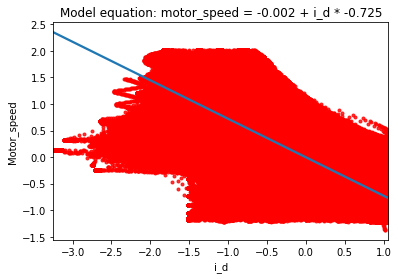

In [20]:
#Model Visualization 
g=sns.regplot(df['i_d'] , df['motor_speed'], 
              ci=None, scatter_kws={'color': 'r', 's':9})
g.set_title('Model equation: motor_speed = -0.002 + i_d * -0.725')
g.set_ylabel('Motor_speed')
g.set_xlabel('i_d');

In [21]:
from sklearn.metrics import r2_score,mean_squared_error

mse=mean_squared_error(y, model.fittedvalues)
rmse=np.sqrt(mse)
rmse

0.6917872418443056

In [22]:
k_t=pd.DataFrame({'Real_values':y[0:50], 
                  'Predicted_values' :model.fittedvalues[0:50]})
k_t['error']=k_t['Real_values']-k_t['Predicted_values']
k_t.head()

,Real_values,Predicted_values,error
0,-1.222428,-0.747914,-0.474514
1,-1.222429,-0.747869,-0.474561
2,-1.222428,-0.747824,-0.474604
3,-1.222430,-0.750285,-0.472145
4,-1.222429,-0.749534,-0.472895


In [23]:
model.resid[0:10] #It is easy way to learn residuals.

0   -0.474514
1   -0.474561
2   -0.474604
3   -0.472145
4   -0.472895
5   -0.473457
6   -0.473848
7   -0.474130
8   -0.474315
9   -0.474471
dtype: float64

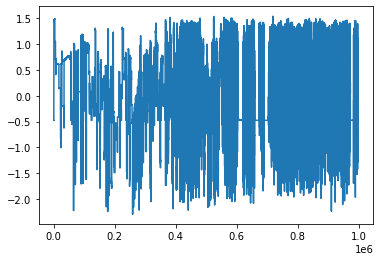

In [24]:
plt.plot(model.resid);

### Multiple Linear Regression <a class="anchor" id="chapter2"></a>

In [25]:
X=df.drop("motor_speed", axis=1)
y=df["motor_speed"]

In [26]:
from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=42)

training=df.copy()

In [27]:
lm=sm.OLS(y_train, X_train)

model=lm.fit()
model.summary() #All coefficients are significant for the model by looking at the p-value. ( P>|t| )

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            motor_speed   R-squared (uncentered):                   0.928
Model:                            OLS   Adj. R-squared (uncentered):              0.928
Method:                 Least Squares   F-statistic:                          9.362e+05
Date:                Sun, 29 Nov 2020   Prob (F-statistic):                        0.00
Time:                        16:21:44   Log-Likelihood:                         -83310.
No. Observations:              798456   AIC:                                  1.666e+05
Df Residuals:                  798445   BIC:                                  1.668e+05
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
ambient           -0.0504      0.000   -131.970      0.000      -0.051      -0.050
coolant            0.4090      0.002    218.116      0.000       0.405       0.413
u_d               -0.1658      0.001   -255.005      0.000      -0.167      -0.165
u_q                0.5394      0.000   1471.356      0.000       0.539       0.540
torque            -0.3414      0.005    -70.365      0.000      -0.351      -0.332
i_d               -0.6580      0.001  -1268.142      0.000      -0.659      -0.657
i_q                0.1355      0.005     29.693      0.000       0.127       0.144
pm                 0.1061      0.001    170.807      0.000       0.105       0.107
stator_yoke       -1.6278      0.006   -282.305      0.000      -1.639      -1.617
stator_tooth       2.3218      0.008    304.587      0.000       2.307       2.337
stator_winding    -1.1714      0.004   -310.265      0.000      -1.179      -1.164
==============================================================================
Omnibus:                    43490.214   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           169220.780
Skew:                          -0.112   Prob(JB):                         0.00
Kurtosis:                       5.244   Cond. No.                         69.2
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
#Root Mean Squared Error for Train
rmse1=np.sqrt(mean_squared_error(y_train,model.predict(X_train)))
rmse1

0.26858166812562484

In [29]:
#Root Mean Squared Error for Test
rmse2=np.sqrt(mean_squared_error(y_test,model.predict(X_test)))
rmse2

0.2682388574654593

In [30]:
#Model Tuning for Multiple Linear Regression
model = LinearRegression().fit(X_train,y_train)
cross_val_score1=cross_val_score(model, X_train, y_train, cv=10, scoring='r2').mean() #verified score value for train model
print('Verified R2 value for Training model: ' + str(cross_val_score1))

cross_val_score2=cross_val_score(model, X_test, y_test, cv=10, scoring='r2').mean() #verified score value for test model
print('Verified R2 value for Testing Model: ' + str(cross_val_score2))

Verified R2 value for Training model: 0.9280428823529187
Verified R2 value for Testing Model: 0.9281824494591501


In [31]:
RMSE1=np.sqrt(-cross_val_score(model, X_train, y_train, cv=10, 
                               scoring='neg_mean_squared_error')).mean() #verified RMSE score value for train model
print('Verified RMSE value for Training model: ' + str(RMSE1))

RMSE2=np.sqrt(-cross_val_score(model, X_test, y_test, cv=10, 
                               scoring='neg_mean_squared_error')).mean() #verified RMSE score value for test model
print('Verified RMSE value for Testing Model: ' + str(RMSE2))

Verified RMSE value for Training model: 0.26858491392392614
Verified RMSE value for Testing Model: 0.2682574151523962


/Users/edwinandrew/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/edwinandrew/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


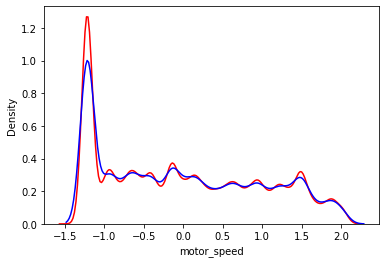

In [32]:
#Visualizing for Multiple Linear Regression y values

import seaborn as sns
ax1 = sns.distplot(y_train, hist=False, color="r", label="Actual Value")
sns.distplot(y_test, hist=False, color="b", label="Fitted Values" , ax=ax1);

### Principle Component Regression <a class="anchor" id="chapter3"></a>

In [33]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

pca=PCA()
X_reduced_train=pca.fit_transform(scale(X_train))

In [34]:
explained_variance_ratio=np.cumsum(np.round(pca.explained_variance_ratio_ , decimals=4)* 100)[0:20]

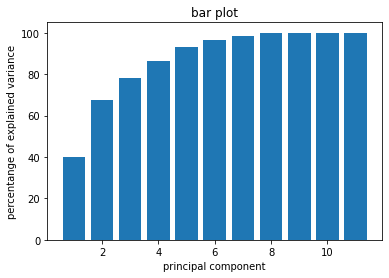

In [35]:
plt.bar(x=range(1, len(explained_variance_ratio)+1), height=explained_variance_ratio)
plt.ylabel('percentange of explained variance')
plt.xlabel('principal component')
plt.title('bar plot')
plt.show()
# 7 component is enough for model.

In [36]:
lm=LinearRegression()
pcr_model=lm.fit(X_reduced_train,y_train)
print('Intercept: ' + str(pcr_model.intercept_))
print('Coefficients: ' + str(pcr_model.coef_))

Intercept: -0.005461278328146824
Coefficients: [-0.1609411   0.15132585  0.75254894 -0.17289487  0.01113056 -0.11722998
 -0.38240312 -0.31081298  0.14826283  0.59796002 -3.03281375]


In [37]:
#Prediction
y_pred=pcr_model.predict(X_reduced_train)
np.sqrt(mean_squared_error(y_train,y_pred))

0.2685807776550948

In [38]:
df['motor_speed'].mean()

-0.006335507987812318

In [39]:
#R squared
r2_score(y_train,y_pred)

0.9280471315857464

In [40]:
# Prediction For testing error 
pca2=PCA()

X_reduced_test=pca2.fit_transform(scale(X_test))
pcr_model2=lm.fit(X_test,y_test)

y_pred=pcr_model2.predict(X_reduced_test)

print('RMSE for test model : ' +str(np.sqrt(mean_squared_error(y_test,y_pred))))

RMSE for test model : 1.4460837467050913


In [41]:
#Model Tuning for PCR

lm=LinearRegression()
pcr_model=lm.fit(X_reduced_train[:,0:10],y_train)
y_pred=pcr_model.predict(X_reduced_test[:,0:10])

from sklearn import model_selection

cv_10=model_selection.KFold(n_splits=10,
                           shuffle=True,
                           random_state=1)

In [42]:
lm=LinearRegression()
RMSE=[]

for i in np.arange(1,X_reduced_train.shape[1] + 1):
    score=np.sqrt(-1*model_selection.cross_val_score(lm,
                                                    X_reduced_train[:,:i],
                                                    y_train.ravel(),
                                                    cv=cv_10,
                                                    scoring='neg_mean_squared_error').mean())
    RMSE.append(score)

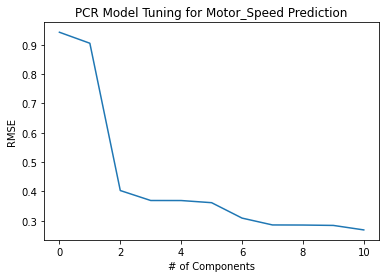

In [43]:
plt.plot(RMSE)
plt.xlabel('# of Components')
plt.ylabel('RMSE')
plt.title('PCR Model Tuning for Motor_Speed Prediction'); 

10 component is good for the model because RMSE value is the smallest for this component number. That's why there is no need to tune the model.

### KNN Regression <a class="anchor" id="chapter4"></a>

In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor

from warnings import filterwarnings
filterwarnings('ignore')

In [45]:
knn_model=KNeighborsRegressor().fit(X_train, y_train)
y_pred=knn_model.predict(X_test)

In [46]:
y_pred.shape

(199614,)

In [47]:
#Model Tuning (learning best n_neighbors hyperparameter)
knn_params={'n_neighbors' : np.arange(1,5,1)}

knn=KNeighborsRegressor()
knn_cv_model=GridSearchCV(knn, knn_params, cv=5)

knn_cv_model.fit(X_train,y_train)
knn_cv_model.best_params_["n_neighbors"]

2

In [48]:
# Train error values from n=1 up n=2
RMSE=[]
RMSE_CV=[]
for k in range(2):
    k=k+1
    knn_model=KNeighborsRegressor(n_neighbors=k).fit(X_train, y_train)
    y_pred=knn_model.predict(X_train)
    rmse=np.sqrt(mean_squared_error(y_train,y_pred))
    rmse_cv=np.sqrt(-1*cross_val_score(knn_model,X_train,y_train,cv=2,
                                       scoring='neg_mean_squared_error').mean())

    RMSE.append(rmse)
    RMSE_CV.append(rmse_cv)

    print("RMSE value: ", rmse, 'for k= ',k,
          "RMSE values with applying Cross Validation: ", rmse_cv)

RMSE value:  0.0 for k=  1 RMSE values with applying Cross Validation:  0.03758055605499355
RMSE value:  0.014334014446882232 for k=  2 RMSE values with applying Cross Validation:  0.03571030046857799


In [49]:
#Model Tuning according to best parametre for KNN Regression
knn_tuned=KNeighborsRegressor(n_neighbors=knn_cv_model.best_params_["n_neighbors"])
knn_tuned.fit(X_train,y_train)
np.sqrt(mean_squared_error(y_test,knn_tuned.predict(X_test)))

0.02513912047426212

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score,mean_squared_error

### Polynomial Regression <a class="anchor" id="chapter5"></a>

Coefficients: 
 [-0.05038711  0.40898769 -0.1658122   0.53942731 -0.34137905 -0.65802735
  0.13545928  0.10610514 -1.62781924  2.32178043 -1.17138889]
Variance score: 0.9282002772131744


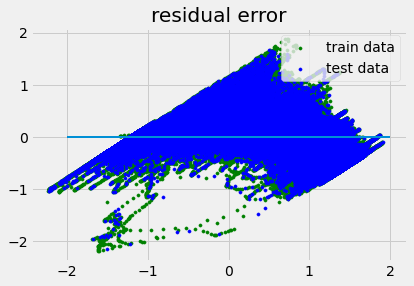

In [51]:
#Plotting Residual in Linear Regression 

from sklearn import linear_model,metrics
#Create linear regression object
reg=linear_model.LinearRegression()

#train the model using the train data sets
reg.fit(X_train,y_train)

#regression coefficients
print("Coefficients: \n", reg.coef_)

#Variance score
print("Variance score: {}".format(reg.score(X_test,y_test)))

plt.style.use('fivethirtyeight')

#plotting residual errors in training data
plt.scatter(reg.predict(X_train),reg.predict(X_train)-y_train, 
            color="green", s=10, label="train data")

#plotting residual errors in test data
plt.scatter(reg.predict(X_test),reg.predict(X_test)-y_test, 
            color="blue", s=10, label="test data")

#plot line for zero residual error
plt.hlines(y=0,xmin=-2, xmax=2, linewidth=2)

#plot legend
plt.legend(loc='upper right')

#plot title
plt.title("residual error")

plt.show()

In [52]:
quad = PolynomialFeatures (degree = 2)
x_quad = quad.fit_transform(X_train)

X_train,X_test,y_train,y_test = train_test_split(x_quad,y_train, random_state = 0)

plr = LinearRegression().fit(X_train,y_train)

Y_train_pred = plr.predict(X_train)
Y_test_pred = plr.predict(X_test)

print('Polynomial Linear Regression:' ,plr.score(X_test,y_test))

Polynomial Linear Regression: 0.9950164956622372
